In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(font_scale=.75)


from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


In [2]:
# ladda datan och gör uppdelning

mydata_train= pd.read_csv ('mnist_train.csv')
mydata_test= pd.read_csv ('mnist_test.csv')

X = mydata_train.iloc[:, 1:].to_numpy()
y = mydata_train.iloc[:, 0].to_numpy()

# Testdata (för slutlig utvärdering)
X_test = mydata_test.iloc[:, 1:].to_numpy()
y_test = mydata_test.iloc[:, 0].to_numpy()



In [11]:
X_train_sample, _, y_train_sample, _ = train_test_split(
    X, y, train_size=mittsvm_size, stratify=y, random_state=42)

In [37]:
# Begränsa datasetet till x antal bilder

mittsvm_size = 20000
X_train_sample, _, y_train_sample, _ = train_test_split(
    X, y, train_size=mittsvm_size, stratify=y, random_state=42
)

# Skapa pipeline för SVM med PCA och standardisering
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Skala datan
    ('pca', PCA(n_components=2)),  # dimensionsreducering
    ('svm', SVC(kernel='rbf'))     # kärna (kernel)
])

# Träna modellen på det mindre datasetet
svm_pipeline.fit(X_train_sample, y_train_sample)


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2)),
                ('svm', SVC())])

           0        1        2        3        4        5        6        7    \
count  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0   
mean       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
std        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
25%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
50%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
75%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
max        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

           8        9    ...          774           775           776  \
count  20000.0  20000.0  ...  20000.00000  20000.000000  20000.000000   
mean       0.0      0.0  ...      0.18395      0.053400      0.022300   
std        0.0      0.0  ...      5.79195      2.60

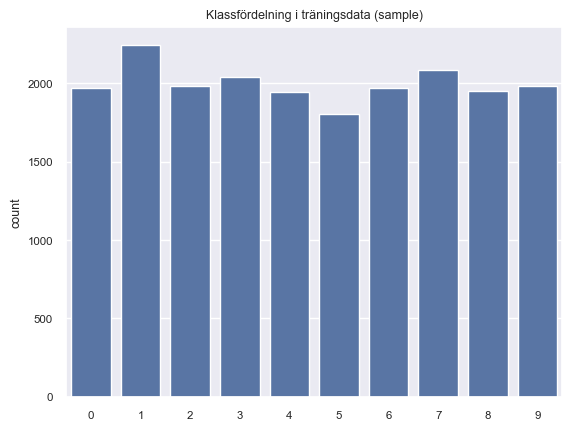

Max pixelvärde: 255
Min pixelvärde: 0
Antal saknade värden i datan: 0


In [38]:
# Dataanalys för det mindre urvalet

print(pd.DataFrame(X_train_sample).describe())

# Kontrollera saknade värden
print(pd.DataFrame(X_train_sample).isnull().sum())

# Klassfördelning
print(pd.Series(y_train_sample).value_counts())

sns.countplot(x=y_train_sample)
plt.title('Klassfördelning i träningsdata (sample)')
plt.show()

# Kontroll av normalisering
print(f"Max pixelvärde: {X_train_sample.max()}")
print(f"Min pixelvärde: {X_train_sample.min()}")

print("Antal saknade värden i datan: " + str(pd.DataFrame(X_train_sample).isnull().sum().sum()))
 #printar ut antal saknade värden



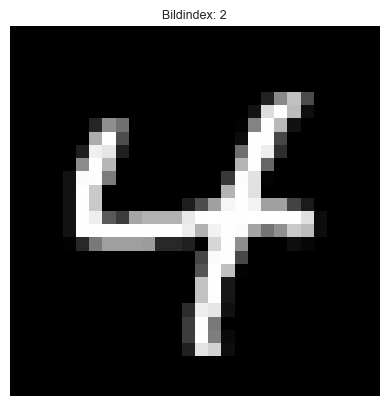

Label för bild med index 2 är: 4


In [22]:
# verifierar att rätt label i x och y stämmer överens

index = 2
verif_digit = X_train_sample[index]
verif_digit_image = verif_digit.reshape(28, 28)

# Verifiera label för en specifik bild
plt.imshow(verif_digit_image, cmap="gray")
plt.title(f"Bildindex: {index}")
plt.axis("off")
plt.show()

# Visa bilden och dess label
print(f"Label för bild med index {index} är: {y_train_sample[index]}")





Bästa parametrar för SVM med PCA:
{'svm__kernel': 'rbf', 'svm__gamma': 0.001, 'svm__C': 10, 'pca__n_components': 100}
Best score: 0.9585

UTVÄRDERING PÅ TESTDATA:

Accuracy (test): 0.9645



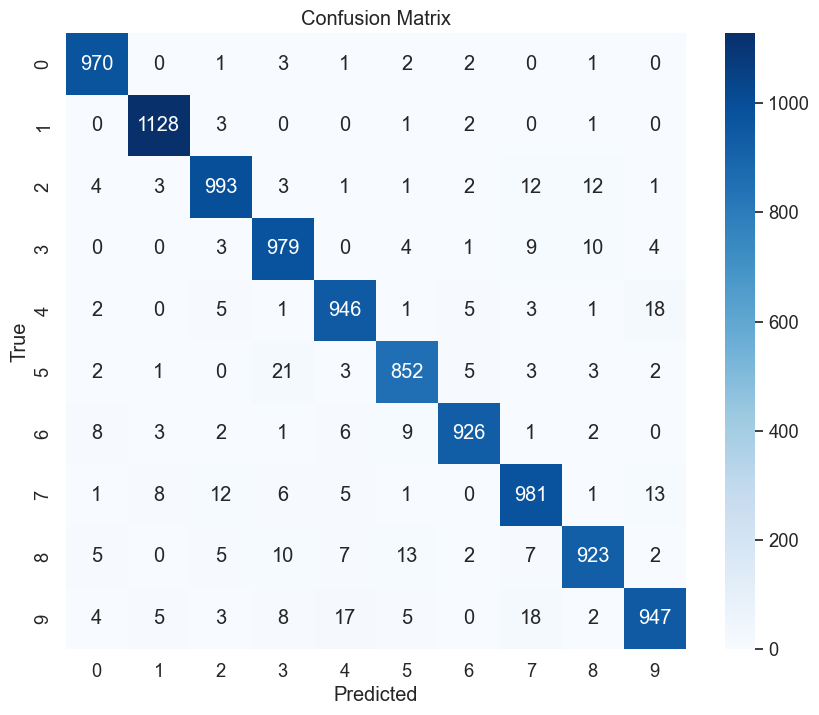


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.96      0.96      1032
           3       0.95      0.97      0.96      1010
           4       0.96      0.96      0.96       982
           5       0.96      0.96      0.96       892
           6       0.98      0.97      0.97       958
           7       0.95      0.95      0.95      1028
           8       0.97      0.95      0.96       974
           9       0.96      0.94      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [45]:
# Skapa och köra RandomizedSearchCV för träning och test

# Definiera parametergrid för både linear och rbf
# ========================
svm_param_grid = {
    'pca__n_components': [30, 50, 100],  # Testa olika antal komponenter
    'svm__C': [0.1, 1, 10],             # Justera C för att hitta bästa marginalstorlek
    'svm__kernel': ['linear', 'rbf'],  # Testa både linear och rbf
    'svm__gamma': [0.001, 0.01, 0.1]  # Gamma värden
}

svm_random_search = RandomizedSearchCV(
    estimator=svm_pipeline,
    param_distributions=svm_param_grid,
    n_iter=5,  # Testa 5 slumpmässiga kombinationer
    cv=3,      # 3-faldig korsvalidering
    n_jobs=-1,  # Använd alla tillgängliga kärnor
    random_state=42
)

# Träna modellen med RandomizedSearchCV
svm_random_search.fit(X_train_sample, y_train_sample)

# ========================
# Skriva ut bästa parametrarna
# ========================
print("\n========================")
print("Bästa parametrar för SVM med PCA:")
print("========================")
print(svm_random_search.best_params_)
print(f"Best score: {svm_random_search.best_score_:.4f}")

# ========================
# Gör prediktion på testdata
# ========================
y_pred = svm_random_search.best_estimator_.predict(X_test)

# ========================
# Utvärdera modellen på testdatan
# ========================
print("\n========================")
print("UTVÄRDERING PÅ TESTDATA:")
print("========================")
print(f"\nAccuracy (test): {accuracy_score(y_test, y_pred):.4f}")

print("\n========================")
#print("Confusion Matrix:")
print("========================")
#print(confusion_matrix(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

# Skapa etiketter dynamiskt baserat på antalet klasser
labels = [str(i) for i in range(cm.shape[0])]

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

print("\n========================")
print("Classification Report:")
print("========================")
print(classification_report(y_test, y_pred))

In [43]:
# skapa tabell för att se randomized search resultat

pd.DataFrame(svm_random_search.cv_results_).sort_values(by='mean_test_score', ascending=False)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svm__kernel,param_svm__gamma,param_svm__C,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,26.190487,0.264453,6.906426,0.203298,rbf,0.001,10.0,100,"{'svm__kernel': 'rbf', 'svm__gamma': 0.001, 's...",0.956052,0.956652,0.962646,0.95845,0.002977,1
4,22.941727,0.515744,1.679342,0.046386,linear,0.010,1.0,100,"{'svm__kernel': 'linear', 'svm__gamma': 0.01, ...",0.920654,0.917804,0.925443,0.92130,0.003152,2
2,102.702719,6.307813,0.988700,0.157614,linear,0.001,10.0,100,"{'svm__kernel': 'linear', 'svm__gamma': 0.001,...",0.918104,0.913754,0.921392,0.91775,0.003128,3
3,99.003589,4.282882,0.899760,0.143412,linear,0.001,10.0,30,"{'svm__kernel': 'linear', 'svm__gamma': 0.001,...",0.908055,0.904455,0.914191,0.90890,0.004020,4
0,42.677515,0.760885,12.597370,0.312788,rbf,0.001,0.1,50,"{'svm__kernel': 'rbf', 'svm__gamma': 0.001, 's...",0.904005,0.899205,0.909541,0.90425,0.004223,5


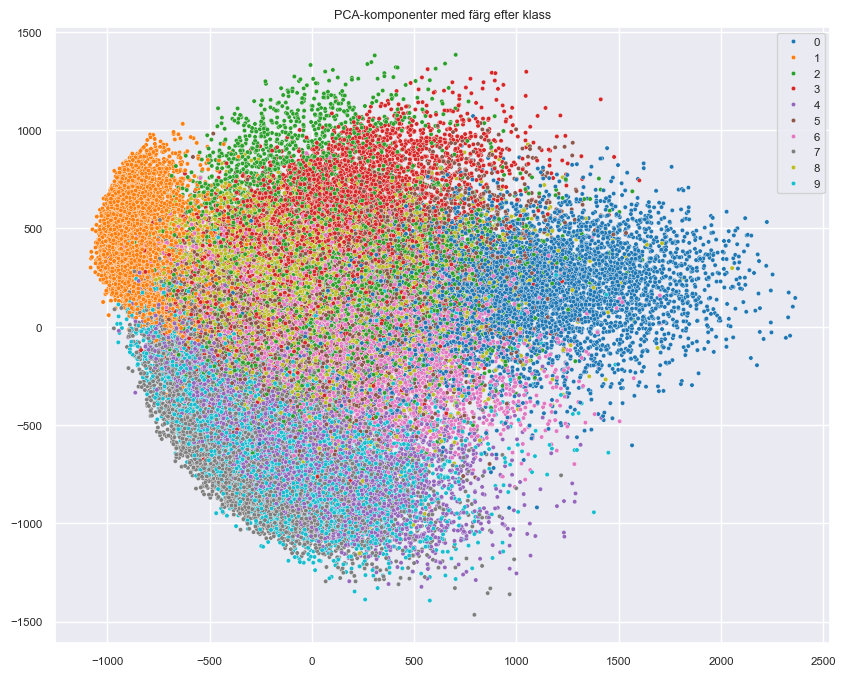

In [25]:
# plotta klasser efter färg, samt PCA med två komponenter för visualisering

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="tab10", s=10)
plt.title("PCA-komponenter med färg efter klass")
plt.show()


   True  Predicted  Count
0     5          3     21
1     4          9     18
2     9          7     18
3     9          4     17
4     8          5     13
5     7          9     13
6     2          7     12
7     2          8     12
8     7          2     12
9     8          3     10


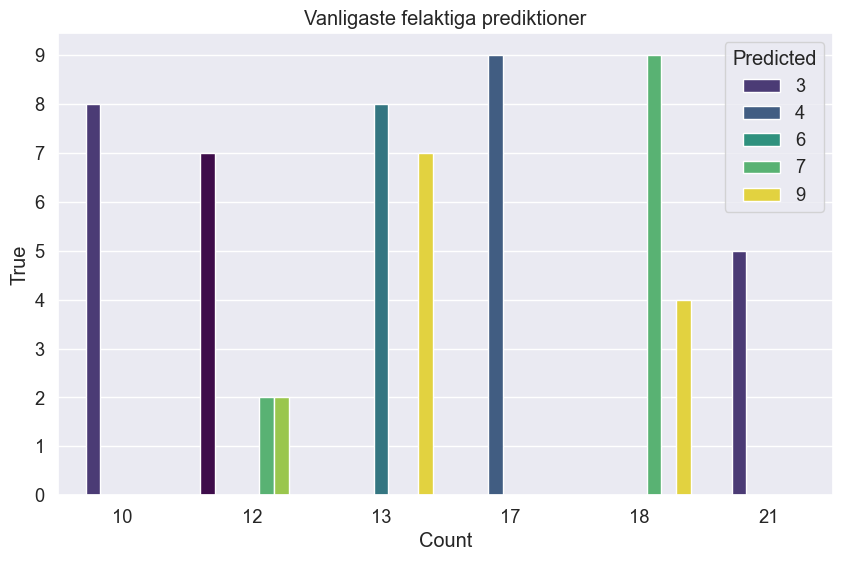

In [46]:
# Hitta felaktiga prediktioner

misclassified = pd.DataFrame({'True': y_test, 'Predicted': y_pred})
misclassified = misclassified[misclassified['True'] != misclassified['Predicted']]

# Räkna ihop de vanligaste felen
summary = misclassified.value_counts().reset_index(name='Count')

# Visa de 10 vanligaste felen
print(summary.head(10))

# Rita en barplot för de vanligaste misstagen
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='True', hue='Predicted', data=summary.head(10), palette='viridis')

# Tvinga fram alla siffror (0–9) på y-axeln
plt.yticks(range(10))

plt.title('Vanligaste felaktiga prediktioner')
plt.show()